In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

%matplotlib inline

from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
from numba import jit

@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

@jit
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    return 'MCC', best_mcc

In [2]:
dtrain = xgb.DMatrix('dtrain.buffer')
dvalid = xgb.DMatrix('dvalid.buffer')

In [3]:
dtrain.get_label().sum()+dvalid.get_label().sum()

6879.0

In [4]:
dtrain.num_row()+dvalid.num_row()

1183747

In [8]:
'''
df1 = pd.read_csv('../input_orig/train_numeric.csv', usecols=['Id','Response'])

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1, df1.Response.values, test_size=0.1, random_state=42, stratify=df1.Response.values)

dvalid = dtrain.slice(X_test.index)
dvalid.num_row(), X_test.shape
dtrain = dtrain.slice(X_train.index)
dtrain.num_row(), X_train.shape

#dtrain.save_binary('dtrain.buffer')
#dvalid.save_binary('dvalid.buffer')

In [5]:
y = dtrain.get_label()
prior = np.sum(y) / (1.*len(y))

In [6]:
spw = 1176868/6879.0

In [7]:
prior1 = 6879.0/1183747

In [8]:
xgb_params1 = {
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'subsample': 1,
    'learning_rate': 0.01,
    'max_depth': 48,
    'min_child_weight': 1,
    'gamma': 0,
    'base_score': prior1,
    'tree_method': 'exact',
    'objective': 'binary:logistic',
    'silent': 0,
    'seed': 12,
    'nthread': 22
}
#'tree_method': 'exact',
evals  = [(dtrain,'train'), (dvalid,'eval')]
bst1 = xgb.train(xgb_params1, dtrain, num_boost_round=50000, 
          evals=evals, early_stopping_rounds=50, 
          verbose_eval=1, feval=mcc_eval, maximize=True)

[0]	train-MCC:0.355146	eval-MCC:0.348413
Multiple eval metrics have been passed: 'eval-MCC' will be used for early stopping.

Will train until eval-MCC hasn't improved in 50 rounds.
[1]	train-MCC:0.378132	eval-MCC:0.371776
[2]	train-MCC:0.382295	eval-MCC:0.380588
[3]	train-MCC:0.387847	eval-MCC:0.381795
[4]	train-MCC:0.402856	eval-MCC:0.384382
[5]	train-MCC:0.416661	eval-MCC:0.389715
[6]	train-MCC:0.42947	eval-MCC:0.389715
[7]	train-MCC:0.445147	eval-MCC:0.390397
[8]	train-MCC:0.453546	eval-MCC:0.39205
[9]	train-MCC:0.462495	eval-MCC:0.392256
[10]	train-MCC:0.476287	eval-MCC:0.392465
[11]	train-MCC:0.481472	eval-MCC:0.393369
[12]	train-MCC:0.492485	eval-MCC:0.392756
[13]	train-MCC:0.503573	eval-MCC:0.394271
[14]	train-MCC:0.509848	eval-MCC:0.396069
[15]	train-MCC:0.523071	eval-MCC:0.396488
[16]	train-MCC:0.534986	eval-MCC:0.400054
[17]	train-MCC:0.545571	eval-MCC:0.40094
[18]	train-MCC:0.553057	eval-MCC:0.399376
[19]	train-MCC:0.56319	eval-MCC:0.398919
[20]	train-MCC:0.574661	eval-MCC:

In [9]:
bst2 = xgb.train(xgb_params1, dtrain, xgb_model=bst1, num_boost_round=5000, early_stopping_rounds=50, 
                 evals=evals, verbose_eval=1, feval=mcc_eval, maximize=True)

[0]	train-MCC:0.984548	eval-MCC:0.424026
Multiple eval metrics have been passed: 'eval-MCC' will be used for early stopping.

Will train until eval-MCC hasn't improved in 50 rounds.
[1]	train-MCC:0.98476	eval-MCC:0.424026
[2]	train-MCC:0.984947	eval-MCC:0.424026
[3]	train-MCC:0.985177	eval-MCC:0.42433
[4]	train-MCC:0.985362	eval-MCC:0.424606
[5]	train-MCC:0.985519	eval-MCC:0.42433
[6]	train-MCC:0.985741	eval-MCC:0.424606
[7]	train-MCC:0.985926	eval-MCC:0.42433
[8]	train-MCC:0.986159	eval-MCC:0.424606
[9]	train-MCC:0.986435	eval-MCC:0.424606
[10]	train-MCC:0.986802	eval-MCC:0.424606
[11]	train-MCC:0.986893	eval-MCC:0.424606
[12]	train-MCC:0.986984	eval-MCC:0.424606
[13]	train-MCC:0.987082	eval-MCC:0.424606
[14]	train-MCC:0.987263	eval-MCC:0.424606
[15]	train-MCC:0.987443	eval-MCC:0.424606
[16]	train-MCC:0.987445	eval-MCC:0.424606
[17]	train-MCC:0.987639	eval-MCC:0.424606
[18]	train-MCC:0.987813	eval-MCC:0.424606
[19]	train-MCC:0.987907	eval-MCC:0.425188
[20]	train-MCC:0.988194	eval-MCC:

In [10]:
bst3 = xgb.train(xgb_params1, dtrain, xgb_model=bst2, num_boost_round=5000, early_stopping_rounds=50, 
                 evals=evals, verbose_eval=1, feval=mcc_eval, maximize=True)

[0]	train-MCC:0.997442	eval-MCC:0.429576
Multiple eval metrics have been passed: 'eval-MCC' will be used for early stopping.

Will train until eval-MCC hasn't improved in 50 rounds.
[1]	train-MCC:0.997442	eval-MCC:0.429576
[2]	train-MCC:0.997442	eval-MCC:0.429773
[3]	train-MCC:0.997533	eval-MCC:0.429773
[4]	train-MCC:0.997534	eval-MCC:0.430014
[5]	train-MCC:0.997534	eval-MCC:0.430588
[6]	train-MCC:0.997534	eval-MCC:0.43013
[7]	train-MCC:0.997625	eval-MCC:0.43013
[8]	train-MCC:0.997625	eval-MCC:0.430588
[9]	train-MCC:0.997625	eval-MCC:0.430588
[10]	train-MCC:0.997716	eval-MCC:0.430588
[11]	train-MCC:0.997716	eval-MCC:0.430502
[12]	train-MCC:0.997718	eval-MCC:0.431071
[13]	train-MCC:0.997718	eval-MCC:0.430588
[14]	train-MCC:0.997718	eval-MCC:0.430588
[15]	train-MCC:0.997809	eval-MCC:0.430748
[16]	train-MCC:0.997809	eval-MCC:0.430829
[17]	train-MCC:0.9979	eval-MCC:0.430829
[18]	train-MCC:0.9979	eval-MCC:0.430748
[19]	train-MCC:0.9979	eval-MCC:0.431315
[20]	train-MCC:0.997991	eval-MCC:0.43

In [12]:
xgb_params2 = {
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'subsample': 1,
    'learning_rate': 0.1,
    'max_depth': 48,
    'min_child_weight': 1,
    'gamma': 0,
    'base_score': prior1,
    'tree_method': 'exact',
    'objective': 'binary:logistic',
    'silent': 0,
    'seed': 12,
    'nthread': 22
}
bst4 = xgb.train(xgb_params2, dtrain, xgb_model=bst3, num_boost_round=5000, early_stopping_rounds=50, 
                 evals=evals, verbose_eval=1, feval=mcc_eval, maximize=True)

[0]	train-MCC:0.999634	eval-MCC:0.434645
Multiple eval metrics have been passed: 'eval-MCC' will be used for early stopping.

Will train until eval-MCC hasn't improved in 50 rounds.
[1]	train-MCC:0.999634	eval-MCC:0.43488
[2]	train-MCC:0.999634	eval-MCC:0.433744
[3]	train-MCC:0.999634	eval-MCC:0.434551
[4]	train-MCC:0.999634	eval-MCC:0.433113
[5]	train-MCC:0.999634	eval-MCC:0.433671
[6]	train-MCC:0.999634	eval-MCC:0.435117
[7]	train-MCC:0.999634	eval-MCC:0.43423
[8]	train-MCC:0.999634	eval-MCC:0.435923
[9]	train-MCC:0.999634	eval-MCC:0.436161
[10]	train-MCC:0.999634	eval-MCC:0.434792
[11]	train-MCC:0.999634	eval-MCC:0.434073
[12]	train-MCC:0.999634	eval-MCC:0.434551
[13]	train-MCC:0.999634	eval-MCC:0.433503
[14]	train-MCC:0.999634	eval-MCC:0.434476
[15]	train-MCC:0.999634	eval-MCC:0.4364
[16]	train-MCC:0.999634	eval-MCC:0.435036
[17]	train-MCC:0.999634	eval-MCC:0.434551
[18]	train-MCC:0.999634	eval-MCC:0.434758
[19]	train-MCC:0.999634	eval-MCC:0.436025
[20]	train-MCC:0.999634	eval-MCC:

In [ ]:
xgb_params3 = {
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'subsample': 1,
    'learning_rate': 0.01,
    'max_depth': 48,
    'min_child_weight': 1,
    'gamma': 0.1,
    'base_score': prior1,
    'tree_method': 'exact',
    'objective': 'binary:logistic',
    'silent': 0,
    'seed': 12,
    'nthread': 22
}
bst5 = xgb.train(xgb_params3, dtrain, xgb_model=bst3, num_boost_round=5000, early_stopping_rounds=50, 
                 evals=evals, verbose_eval=1, feval=mcc_eval, maximize=True)

[0]	train-MCC:0.999634	eval-MCC:0.434645
Multiple eval metrics have been passed: 'eval-MCC' will be used for early stopping.

Will train until eval-MCC hasn't improved in 50 rounds.
[1]	train-MCC:0.999634	eval-MCC:0.434645
[2]	train-MCC:0.999634	eval-MCC:0.434645
[3]	train-MCC:0.999634	eval-MCC:0.434645
[4]	train-MCC:0.999634	eval-MCC:0.434645
[5]	train-MCC:0.999634	eval-MCC:0.434671
[6]	train-MCC:0.999634	eval-MCC:0.435219
[7]	train-MCC:0.999634	eval-MCC:0.435115
[8]	train-MCC:0.999634	eval-MCC:0.434892
[9]	train-MCC:0.999634	eval-MCC:0.435115
[10]	train-MCC:0.999634	eval-MCC:0.435115
[11]	train-MCC:0.999634	eval-MCC:0.435115
[12]	train-MCC:0.999634	eval-MCC:0.434892
[13]	train-MCC:0.999634	eval-MCC:0.435115
[14]	train-MCC:0.999634	eval-MCC:0.435115
[15]	train-MCC:0.999634	eval-MCC:0.435115
[16]	train-MCC:0.999634	eval-MCC:0.435115
[17]	train-MCC:0.999634	eval-MCC:0.434645
[18]	train-MCC:0.999634	eval-MCC:0.435115
[19]	train-MCC:0.999634	eval-MCC:0.435036
[20]	train-MCC:0.999634	eval-

In [46]:
import operator
importance = bst1.get_fscore(fmap='xgb1.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)

In [47]:
len(importance)

725

In [48]:
bst1.dump_model('429535mcc.dump', fmap='xgb1.fmap', with_stats=True)

In [49]:
bst1.save_model('429535.model')

In [4]:
#bst1 = xgb.Booster()
#bst1.load_model('429535.model')

In [15]:
pred_valid = bst1.predict(dvalid, ntree_limit=155)

0.429534884036 0.4295348840357449


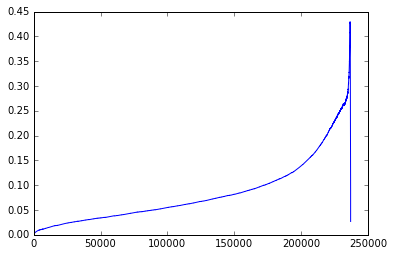

In [16]:
best_proba, best_mcc, y_pred = eval_mcc(dvalid.get_label(), pred_valid, show=True)

In [17]:
best_proba

0.29268866777420044

In [10]:
dtest = xgb.DMatrix('../input_hdf/test_with_faron_sel.buffer')

In [11]:
# generate predictions at the chosen threshold
preds = (bst1.predict(dtest, ntree_limit=155) > best_proba).astype(np.int8)

In [12]:
# and submit
sub = pd.read_csv("../input_orig/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("429535_submission.csv.gz", compression="gzip")